In [1]:
import matplotlib.pyplot as plt
# import scipy.stats as st
import seaborn as sns
import torch.nn as nn
# import pandas as pd
import polars as pl
import numpy as np

import itertools
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

In [18]:
def torch_train_test_split(*tensors, split=.8):
    n_samples = tensors[0].shape[0]
    train_size = int(split * n_samples)
    test_size = n_samples - train_size
    rand_indices = torch.randperm(n_samples)
    train_indices, test_indices = torch.split(rand_indices, [train_size, test_size])
    assert train_indices.shape[0] == train_size, f'{train_indices.shape} != {train_size}'
    assert test_indices.shape[0] == n_samples - train_size, f'{test_indices.shape} != {n_samples - train_size}'

    data_tensors = list()
    for tensor in tensors:
        assert tensor.shape[0] == n_samples
        train_data = tensor[train_indices]
        test_data = tensor[test_indices]
        data_tensors.extend((train_data, test_data))
    return data_tensors
    
class TorchDataset(Dataset):
    def __init__(self, seq2seq_tensor, enc_window=120, dec_window=120):
        assert seq2seq_tensor.ndim == 2
        self._data = seq2seq_tensor
        self.enc_window = enc_window
        self.dec_window = dec_window
        return
    
    @property
    def shape(self):
        return (self._data.shape[0] - (self.enc_window + self.dec_window), 1)

    def __len__(self):
        return self.shape[0]

    def __getitem__(self, index):
        enc_data = self._data[index - self.enc_window:index,:]
        dec_data = self._data[index:self.dec_window + index,:]
        return enc_data, dec_data

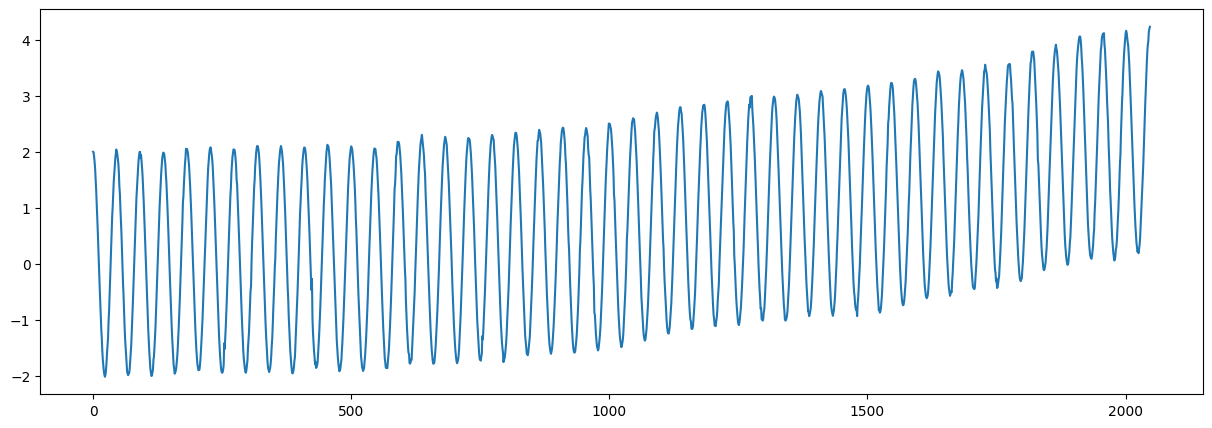

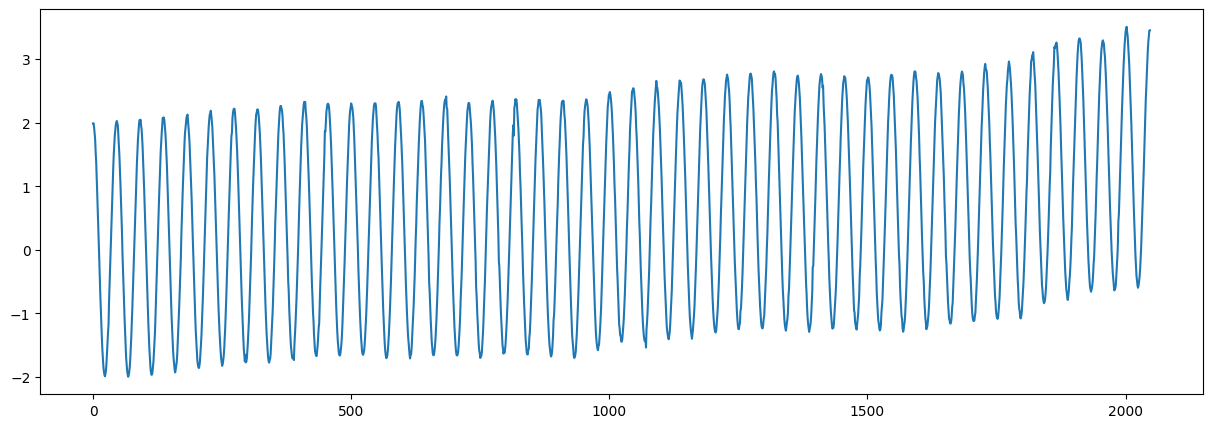

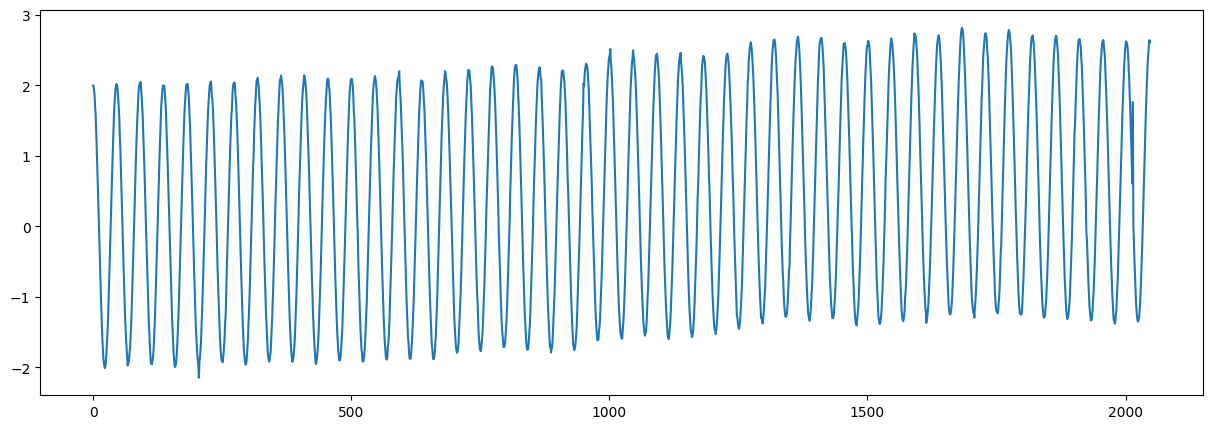

In [19]:
arr_dict = dict()
dataset_samples = 100
size = 2048
slopes = np.linspace(0.0001, .001, 100)
for slope in slopes:
    arr = WaveGen(size=size).linear_phase(n_periods=45).cos().amp(2).t_noise(std=.01, dof=2).sample(n_samples=1).samples
    trend = np.exp(np.cumsum(np.log(np.random.normal(slope, .005, size=size) + 1))) - 1
    arr_dict[slope] = np.squeeze(arr + trend)
                   
for slope in np.random.choice(slopes, size=3):
    plt.figure(figsize=(15,5))
    plt.plot(arr_dict[slope].squeeze())
    plt.show()

In [20]:
# dict concat should pseudo-shuffle?
data = torch.from_numpy(np.stack(list(arr_dict.values()), axis=0))
print(data.shape)
split_idx = int(data.shape[0]*.8)
train_data = data[:split_idx]
test_data = data[split_idx:]


enc_window = 128
dec_window = 128
train_dataset = TorchDataset(train_data, enc_window=enc_window, dec_window=dec_window)
test_dataset = TorchDataset(test_data, enc_window=enc_window, dec_window=dec_window)

torch.Size([100, 2048])


In [30]:
class SineCNNLSTM(nn.Module):
    def __init__(
        self, 
        input_size,
        output_size=1,
        out_channels=16, 
        kernel_size=2, 
        stride=1, 
        drop=.4, 
        hidden_size=32,
        num_layers=1,
    ):
        super(SineCNNLSTM, self).__init__()
        
#         conv1_out_shape = (input_size - kernel_size) // stride + 1
#         pool_out_shape = (conv1_out_shape - pool_kernel) // pool_kernel + 1
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        self.lstm = nn.LSTM(out_channels, hidden_size, num_layers=num_layers)
        self.fc1 = nn.Linear(hidden_size, hidden_size, drop=drop)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.output = nn.Sigmoid()
        return
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.lstm(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.output(x)
        return x

In [31]:
def train(
    model, 
    train_dataset, 
    test_dataset, 
    n_epochs=1000,
    batch_size=64,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.RMSprop,
    early_stop_patience=0,
    test_full=True,
    print_=False,
):
    optimizer = optimizer(model.parameters())
    train_dataloader = DataLoader(train_dataset, batch_size=train_dataset.shape[0], shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=test_dataset.shape[0], shuffle=False)
    if early_stop_patience:
        patience = 0
        model_buffer = None
        loss_buffer = torch.tensor(float('inf'))

    items = list()
    for epoch in range(n_epochs):
        p = print_ & True
        for (train_data, train_labels), (test_data, test_labels) in zip(train_dataloader, test_dataloader):
            avg_train_loss, avg_test_loss = 0, 0
            for i in train_data.shape[0]:
                optimizer.zero_grad()
                train_output = model(train_data[i])

                train_loss = criterion(train_output, train_labels[i])       
                train_loss.backward()
                optimizer.step()
                avg_train_loss += train_loss.item() / train_data.shape[0]

            for i in test_data.shape[0]:
                test_output = model(test_data[i])
                test_loss = criterion(test_output, test_labels[i])
                avg_test_loss += test_loss.item() / test_data.shape[0]

            if p and not epoch % 10:
                print('Train Loss', avg_train_loss)
                print('Test Loss', avg_test_loss)
                p = False
                
        if test_full:
            train_data, train_label = train_dataset[:]
            test_data, test_label = test_dataset[:]
            
            avg_train_loss, avg_test_loss = 0, 0
            for i in train_data.shape[0]:
                train_output = model(train_data[i])
                train_loss = criterion(train_output, train_label[i])
                avg_train_loss += train_loss.item() / train_data.shape[0]
            
            for i in test_data.shape[0]:
                test_output = model(test_data[i])
                test_loss = criterion(test_output, test_label[i])
                avg_test_loss += test_loss.item() / test_data.shape[0]
            
            if early_stop_patience:
                if avg_test_loss > loss_buffer:
                    patience += 1
                    if patience >= early_stop_patience:
                        items = items[:-early_stop_patience]
                        model = model_buffer
                        break
                else:
                    model_buffer = model
                    loss_buffer = avg_test_loss
        elif early_stop_patience:
            warnings.warn('Early Stopping Patience argument unused, full data evaluation at end of epochs is disabled. \n Set test_full to True for early stopping.')
        
        items.append((avg_train_loss, avg_test_loss))
    return model, items

def plot_loss(items, title='', step=1):
    plt.figure(figsize=(16,8))
    train_loss, test_loss = zip(*items)
    colors = sns.color_palette('Spectral', 8)
    sns.lineplot(train_loss[::step], dashes=False, color=colors[0], label='Train MSE')
    sns.lineplot(test_loss[::step], dashes=False, color=colors[3], label='Test MSE')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [32]:
class ProductDict():
    def __init__(self, params):
        self.keys, self.values = zip(*sorted(params.items(), key=lambda x : x[0]))
        self.value_lengths = list(map(len, self.values))
        self.length = np.prod(self.value_lengths)
        return
    
    def __len__(self):
        return self.length
    
    def combinations(self):
        for scalar_values in itertools.product(*self.values):
            yield dict(zip(self.keys, scalar_values))
        return

In [33]:
# out_channels=16, 
# kernel_size=2, 
# stride=1, 
# drop=.4, 
# hidden_size=32,
# num_layers=1,
params = ProductDict({
    'out_channels' : [2,4,8,16],
    'kernel_size' : [2,8,24,48,96,256],
    'stride' : [1,2,4,8,24],
    'drop' : [.2, .4, .6],
    'hidden_size' : [8, 16, 32, 64],
})


columns = sorted(params.keys)
rows = list()
n_epochs = 30

for i, params in enumerate(params.combinations()):
    print(params)
    if params['stride'] is None:
        stride = kernel_size
    if params['stride'] > params['kernel_size']:
        continue
        
    print('Input Set', i + 1, 'out of', len(params), end='\n')
    print(params, sep='|')
    
    model = SineCNNLSTM(
        enc_window,
        **params,
    ).double()
    
    try:
        model, items = train(
            model, 
            train_dataset, 
            test_dataset, 
            n_epochs=n_epochs, 
            test_full=True,
            early_stop_patience=5,
        ) 
    except RuntimeError as re:
        print(re)
        continue
    if not len(items):
        continue
    train_loss, test_loss = zip(*items)
    train_loss = np.mean(train_loss[2:])
    test_loss = np.mean(test_loss[2:])
    
    rows.append(pl.DataFrame({
        **params, 
        **{
            'train_loss':train_loss, 
            'test_loss':test_loss,
        }
    }))

grid_df = pl.concat(rows, how='vertical')
assert grid_df.shape[1] == len(columns), f'{grid_df.shape[1]} != {len(columns)}'
grid_df.write_csv(f'training_io_{pd.to_datetime("today").strftime("%Y-%m-%d:%H")}.csv')
display(grid_df)

{'drop': 0.2, 'hidden_size': 8, 'kernel_size': 2, 'out_channels': 2, 'stride': 1}
Input Set 1 out of 5
{'drop': 0.2, 'hidden_size': 8, 'kernel_size': 2, 'out_channels': 2, 'stride': 1}


TypeError: Linear.__init__() got an unexpected keyword argument 'drop'

In [ ]:
for col in ['out_channels','kernel_size','stride','pool_kernel','dense_size']:
    plt.figure(figsize=(8,5))
    sns.barplot(data=grid_df, x=col, y='test_loss')
    plt.show()

In [ ]:
best_out_channels, best_kernel_size, best_stride, best_pool_kernel = grid_df.iloc[grid_df['test_loss'].argmin(),:4].to_numpy(dtype=np.int32)

# display(best_out_channels, best_kernel_size, best_stride, best_pool_kernel)
model = SineCNN(
    train_dataset.shape[2] - 1,
    out_channels=best_out_channels,
    kernel_size=best_kernel_size,
    stride=best_stride,
    pool_kernel=best_pool_kernel,
).double()

model, items = train(model, train_dataset, test_dataset, n_epochs=100, test_full=True, early_stop_patience=30) 
plot_loss(
    items,
    title=''
)
torch.save(model, 'best_cnnlstm.pt')